# MTSPL
### CV based Image segmentation
An deterministic approach to identify metal scrap pieces on a moving conveyor. Image segmentation and post-processing helps in identifying Value-Added and Non Value Added scrap pieces.


##### Imports

In [18]:
import numpy as np
import pyrealsense2 as rs
import cv2
import matplotlib.pyplot as plt
import math

enter path to ".bag" file

In [19]:
fname = "dc1.bag"

configurating for reading from '.bag' file instead of realsense camera

In [20]:
pipeline = rs.pipeline()
config = rs.config()
rs.config.enable_device_from_file(config, fname)
pipeline.start(config)

# float(2) = code for 'Bone Colormap [black and white]'
colorizer = rs.colorizer(float(2))

Callback for reading from camera

In [21]:
def nothing(x):
    pass

Helper function to find distance between any two points on the RGBD iamge (in pixel units).

In [22]:
def dist(a,b,c,x,y):
    return (a*x + b*y + c)/math.sqrt(a**2 + b**2)

A gradient image generator. [linear gradient from black to white directed along (top left -> bottom right) diagonal]

In [23]:
def correctionMatrix(data, alpha, beta):
    r = data.shape[0]
    c = data.shape[1]
    maxdist = dist(c, -r, r*c, 0, 0)
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            data[i][j] = (dist(c, -r, r*c, -i, j)*alpha/maxdist)+beta
    
    return data

Depth calculations for different regions of interest

In [24]:
def find_depth(points, ground_depth, depth_data, binary, k_size, skip_freq, slice_ratio):
    av_thickness = list()
    med_thickness = list()
    avg_w_from_ground = list()
    avg_b_from_ground = list()


    for i in range(0, len(points)):
        if i % skip_freq == 0:
            white_list = list()
            black_list = list()
            point = points[i][0]
            x = point[1]
            y = point[0]
            for j in range(-1*(k_size//2), (k_size//2)):
                for k in range(-1*(k_size//2), (k_size//2)):
                    # print(x,y,i,j,k)
                    if(binary[x+j][y+k] == 255):
                        white_list.append(depth_data[x+j][y+k])
                    else:
                        black_list.append(depth_data[x+j][y+k])
    
            white_list.sort()
            black_list.sort()
            new_white_list = white_list[int(-len(white_list)/slice_ratio)::1]
            new_black_list = black_list[0::int(len(black_list)/slice_ratio)]
            #mean
            sum = 0
            count = 0
            for val in new_white_list:
                sum += val
                count+=1
            avg_w = sum/count
            avg_w_from_ground.append(ground_depth-avg_w)


            sum = 0
            count = 0
            for val in new_black_list:
                sum += val
                count+=1
            avg_b = sum/count
            avg_b_from_ground.append(ground_depth-avg_b)

            avg_thickness = avg_b - avg_w

            av_thickness.append(avg_thickness)

            med_b = black_list[len(black_list)//2]
            med_w = white_list[len(white_list)//2]
            # print(white_list, " <|> ", black_list)
            med_thickness.append(med_b-med_w)


    av_thickness.sort()

    sum = 0
    c = 0
    for v in av_thickness:
        sum += v
        c+=1
    avg_th2 = sum/c

    sum = 0
    c = 0
    for v in med_thickness:
        sum += v
        c+=1
    med_th = sum/c

    sum = 0
    c = 0
    for v in avg_w_from_ground:
        sum += v
        c+=1
    avg_th3 = sum/c

    sum = 0
    c = 0
    for v in avg_b_from_ground:
        sum += v
        c+=1
    avg_th4 = sum/c

    return avg_th2, med_th, avg_th3, avg_th4



Depth and thickness calculation for approach 1

In [25]:

def find_depth2(edge, depth_data, ground_depth, slice_ratio):
    depths = list()
    for i in range(len(edge)):
        point = edge[i][0]
        x = point[1]
        y = point[0]
        depths.append(depth_data[x][y])
    depths.sort()
    
    depths = depths[-len(depths)//slice_ratio::1]

    sum = 0
    c = 0
    for v in depths:
        sum+=v
        c+=1
    avg_depth = sum/c

    return ground_depth - avg_depth


Slider Widgets for changing threshold values

In [26]:
import ipywidgets.widgets as widgets
import ipywidgets
from IPython.display import display

# canny thresholding sliders
canny_1_1 = widgets.IntSlider(29,0,255,1,description = 'canny threshold 1 - set1')
canny_1_2 = widgets.IntSlider(42,0,255,1,description = 'canny threshold 2 - set1')
canny_2_1 = widgets.IntSlider(29,0,255,1,description = 'canny threshold 1 - set2')
canny_2_2 = widgets.IntSlider(42,0,255,1,description = 'canny threshold 2 - set2')
canny_3_1 = widgets.IntSlider(29,0,255,1,description = 'canny threshold 1 - set3')
canny_3_2 = widgets.IntSlider(42,0,255,1,description = 'canny threshold 2 - set3')


# sliders for other thresholds
kernel_size_median = widgets.IntSlider(5,1,21,2,description = 'kernel median size')
alpha = widgets.IntSlider(100,0,150,1,description = 'alpha')
beta = widgets.IntSlider(0,0,255,1,description = 'beta')
threshold = widgets.IntSlider(65,0,255,1,description = 'threshold')
scale = widgets.IntSlider(20,0,100,1,description = 'scale')

display(ipywidgets.VBox([canny_1_1,canny_1_2, canny_2_1, canny_2_2, canny_3_1, canny_3_2, kernel_size_median, alpha, beta, threshold, scale]))



# cv2.namedWindow("sliders", cv2.WINDOW_FREERATIO)
# cv2.resizeWindow("sliders", 800,800)
# cv2.createTrackbar("canny_thr1_1", "sliders",29,255,nothing)
# cv2.createTrackbar("canny_thr2_1", "sliders",42,255,nothing)
# cv2.createTrackbar("mediankSize", "sliders", 5, 50, nothing)
# cv2.createTrackbar("alp", "sliders",100,150,nothing)
# cv2.createTrackbar("beta", "sliders",0,255,nothing)
# cv2.createTrackbar("thr", "sliders",65,255,nothing)
# cv2.createTrackbar("scale", "sliders",20,100,nothing)
# cv2.createTrackbar("canny_thr1_2", "sliders",29,255,nothing)
# cv2.createTrackbar("canny_thr2_2", "sliders",42,255,nothing)
# cv2.createTrackbar("canny_thr1_3", "sliders",29,255,nothing)
# cv2.createTrackbar("canny_thr2_3", "sliders",42,255,nothing)

Reading camera frames from '.bag' files

In [27]:
# 5 frames for camera adjustment
for i in range(5):
    frame = pipeline.wait_for_frames()

frames = []
for x in range(10):
    frameset = pipeline.wait_for_frames()
    frames.append(frameset.get_depth_frame())
    
pipeline.stop()
print("Frames Captured")

Frames Captured


Displaying RGBD frame before preprocessing.

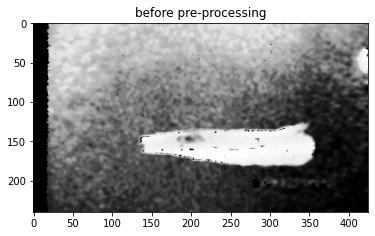

In [28]:
preprocessed = np.asanyarray(colorizer.colorize(frames[0]).get_data())
preprocessed = cv2.resize(preprocessed,(425,240))

plt.title("before pre-processing")
plt.imshow(preprocessed)

# cv2.imshow("before pre-processing", preprocessed)

Initializing filters and using them to remove discontinuities in the raw RGBD frame

In [29]:
decimation = rs.decimation_filter()
spatial = rs.spatial_filter()
temporal = rs.temporal_filter()
hole_filling = rs.hole_filling_filter()
depth_to_disparity = rs.disparity_transform(True)
disparity_to_depth = rs.disparity_transform(False)

for x in range(10):
    frame = frames[x]
    frame = decimation.process(frame)
    frame = depth_to_disparity.process(frame)
    frame = spatial.process(frame)
    frame = temporal.process(frame)
    frame = disparity_to_depth.process(frame)
    frame = hole_filling.process(frame)

Diplaying frame after processing for irregularities

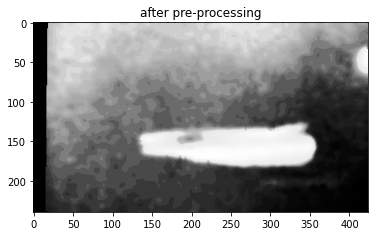

In [30]:
colorized_depth = np.asanyarray(colorizer.colorize(frame).get_data())

plt.title("after pre-processing")
plt.imshow(colorized_depth)

# cv2.imshow("after pre-processing", colorized_depth)

Selecting ROI for ground depth calculation

average ground depth: 656.4 mm


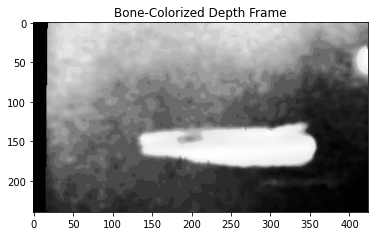

In [31]:
depthf = frame

depthd = np.asanyarray(depthf.get_data())
depthd = depthd[10:230, 30:420]
ground = depthd[50:80, 340:370]
ground_depth = np.average(ground)

depthc = np.asanyarray(colorizer.colorize(depthf).get_data())

print(f"average ground depth: {round(ground_depth,2)} mm")

plt.title("Bone-Colorized Depth Frame")
plt.imshow(depthc)

Normalizing the frame data using min-max normalization

In [32]:
min = 1000
max = 1
originaldepth = np.copy(depthd)

for x in np.nditer(depthd, op_flags=['readonly']):
    if x<min and x!=0:
        min = int(x)
    if x>max:
        max = int(x)

delta  = max-min

for i in range(depthd.shape[0]):
    for j in range(depthd.shape[1]):
        depthd[i][j] = int(254*((max-int(depthd[i][j]))/delta))+1

correctionmatrix = correctionMatrix(np.ones(depthd.shape, np.float32), 1, 0)

flag = False

measurement_scale = 655/221

main loop

In [35]:
from ipywidgets import interactive 

def process(scale, alpha, beta, threshold, thr1_1, thr2_1, kernelsize, thr1_3, thr2_3):
    
    
    newdepthd = np.subtract(depthd, correctionmatrix*scale)

    gray = cv2.cvtColor(cv2.applyColorMap(cv2.convertScaleAbs(newdepthd, alpha=alpha, beta=beta), cv2.COLORMAP_BONE), cv2.COLOR_BGR2GRAY)
    gray = cv2.medianBlur(gray, kernelsize)
    canny = cv2.Canny(gray, thr1_1, thr2_1)
    
    source = gray
    (thresh, Bin) = cv2.threshold(source, threshold, 255, cv2.THRESH_BINARY)
    #(thresh, otsu) = cv2.threshold(source, m, 255, cv2.THRESH_OTSU)
    # cv2.imshow("Binary",Bin)
    (cnts, _) = cv2.findContours(Bin, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

    index = 0
    if (len(cnts) != 0):
        largestContour = cnts[0]
        flag = True
    
    if (flag):
        for i in range(1,len(cnts)):
            if (cv2.contourArea(largestContour) < cv2.contourArea(cnts[i])):
                index = i
                largestContour = cnts[i]
            

    Bin_WithContour = cv2.drawContours(cv2.cvtColor(Bin,cv2.COLOR_GRAY2RGB), cnts, index, (0,255,0), 1)
    t = 2
    x, y, a, b = cv2.boundingRect(largestContour)
    # print(a,b)
    isConvex = cv2.isContourConvex(largestContour)
    cv2.rectangle(Bin_WithContour, (x, y), (x + a - t, y + b - t), (0,0,255), t)

    plt.title(f"Binary segmented with contour{kernelsize}")
    plt.imshow(depthc)



    # cv2.rectangle(gray, (340,50),(370,80),(0,255,0),2)
    # cv2.imshow("depthframe",gray)
    # masked_image = cv2.bitwise_and(gray, Bin)
    # cv2.imshow("masked image", masked_image)


    # canny_binary = cv2.Canny(Bin, thr1_3, thr2_3)

    # depth_list = list()


    pass




# def f(i,f):  #  i is for lower limit f is for the upper limit of threshold 
#     img = cv2.imread('gray.png')

#     _,threshold = cv2.threshold(img,i,f,cv2.THRESH_BINARY)

# #cv2.imshow('thresg',threshold)

#     plt.imshow(threshold,cmap='gray')



#cv2.waitKey()

#cv2.destroyAllWindows()

# scale, alpha, beta, threshold, thr1_1, thr2_1, kernelsize, thr1_3, thr2_3

interactive_plot = interactive(process, scale = scale, alpha=alpha, beta=beta, threshold=threshold, thr1_1 = canny_1_1, thr2_1 = canny_1_2, thr1_3 = canny_3_1, thr2_3 = canny_3_2, kernelsize = kernel_size_median)

interactive_plot

interactive(children=(IntSlider(value=20, description='scale'), IntSlider(value=100, description='alpha', max=…